In [207]:
import pandas as pd
import numpy as np
import csv 

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.inspection import PartialDependenceDisplay

In [131]:
with open('data/intermediate/income_data.txt', 'r') as read_file:
    stripped = (line.strip() for line in read_file)
    lines = (line.split(",") for line in stripped if line)
    with open('data/intermediate/income_data.csv', 'a') as write_file:
        writer = csv.writer(write_file)
        writer.writerows(lines)

In [132]:
df = pd.read_csv("data/intermediate/income_data.csv")
df.head()

,"""NAME""","""GEOID""","""SAEMHI_PT""","""SAEPOVRTALL_PT""","""time""","""state""","""county"""
0,"""Monongalia County""","""54061""","""51070""","""18.3""","""2018""","""54""","""061"""
1,"""NAME""","""GEOID""","""SAEMHI_PT""","""SAEPOVRTALL_PT""","""time""","""state""","""county"""
2,"""Knox County""","""39083""","""56885""","""13.8""","""2018""","""39""","""083"""
3,"""NAME""","""GEOID""","""SAEMHI_PT""","""SAEPOVRTALL_PT""","""time""","""state""","""county"""
4,"""Warren County""","""21227""","""53478""","""16.5""","""2018""","""21""","""227"""


In [133]:
df_clean = df.drop_duplicates()
df_clean = df_clean.drop(1)
df_clean = df_clean.apply(lambda x: x.str.replace('"', ''))
df_clean.columns = df_clean.columns.str.replace('"', '')
df_clean["income"] = [int(x) for x in df_clean["SAEMHI_PT"]]
df_clean["poverty_rate"] = [float(x) for x in df_clean["SAEPOVRTALL_PT"]]
df_clean = df_clean[["NAME", "GEOID", "income", "poverty_rate"]]
df_clean.head()

,NAME,GEOID,income,poverty_rate
0,Monongalia County,54061,51070,18.3
2,Knox County,39083,56885,13.8
4,Warren County,21227,53478,16.5
6,Matagorda County,48321,48830,18.4
8,Chesterfield County,51041,80734,7.6


In [134]:
matched = pd.read_csv("data/intermediate/matched_colleges.csv", index_col = 0)
matched["fips"] = [str(int(x)).zfill(5) if not np.isnan(x) else None for x in matched["fips"]]
matched.head()

,Experiment,Treatment,fips,State
0,"('AlAMU', 1875)",1,01089,Alabama
1,"('AlAMU', 1875)",0,01101,Alabama
2,"('AlAMU', 1875)",0,01087,Alabama
3,"('AubU', 1856)",1,01081,Alabama
4,"('AubU', 1856)",0,01077,Alabama


In [261]:
joined = matched.join(df_clean.set_index("GEOID"), on="fips", how="left")
joined["Year"] = [int(tupule[-5:-1]) for tupule in joined["Experiment"]]
joined["length_time"] = 2018 - joined["Year"]
joined.head()

,Experiment,Treatment,fips,State,NAME,income,poverty_rate,Year,length_time
0,"('AlAMU', 1875)",1,01089,Alabama,Madison County,63755.0,11.9,1875,143
1,"('AlAMU', 1875)",0,01101,Alabama,Montgomery County,49640.0,20.1,1875,143
2,"('AlAMU', 1875)",0,01087,Alabama,Macon County,32495.0,30.2,1875,143
3,"('AubU', 1856)",1,01081,Alabama,Lee County,48937.0,19.0,1856,162
4,"('AubU', 1856)",0,01077,Alabama,Lauderdale County,48707.0,14.0,1856,162


In [254]:
analysis_df = joined.groupby(["Experiment", "Treatment"])[["income", "poverty_rate"]].mean().reset_index()
analysis_df["Year"] = [int(tupule[-5:-1]) for tupule in analysis_df["Experiment"]]
analysis_df["length_time"] = 2018 - analysis_df["Year"]
analysis_df = analysis_df.dropna()
analysis_df.head()

,Experiment,Treatment,income,poverty_rate,Year,length_time
0,"('AkronU', 1870)",0,63689.000000,11.30,1870,148
1,"('AkronU', 1870)",1,58890.000000,12.00,1870,148
2,"('AlAMU', 1875)",0,41067.500000,25.15,1875,143
3,"('AlAMU', 1875)",1,63755.000000,11.90,1875,143
4,"('AlcSU', 1871)",0,39241.333333,19.80,1871,147


In [210]:
X_simp = analysis_df["Treatment"]
X_simp = sm.add_constant(X_simp)
y1 = analysis_df["income"]
y2 = analysis_df["poverty_rate"]

### Simple Linear Regression

These results are not statistically significant!

In [189]:
income_model = sm.OLS(y1, X_simp).fit()
poverty_model = sm.OLS(y2, X_simp).fit()

In [187]:
print(income_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8115
Date:                Sun, 05 May 2024   Prob (F-statistic):              0.369
Time:                        00:40:49   Log-Likelihood:                -2796.5
No. Observations:                 253   AIC:                             5597.
Df Residuals:                     251   BIC:                             5604.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.937e+04   1350.728     43.954      0.0

In [186]:
print(poverty_model.summary())

                            OLS Regression Results                            
Dep. Variable:           poverty_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.240
Date:                Sun, 05 May 2024   Prob (F-statistic):              0.266
Time:                        00:40:42   Log-Likelihood:                -748.52
No. Observations:                 253   AIC:                             1501.
Df Residuals:                     251   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0545      0.412     34.099      0.0

### Linear Regression with Interaction Term

In [215]:
income_time = smf.ols("income ~ Treatment * length_time", analysis_df).fit()
poverty_time = smf.ols("poverty_rate ~ Treatment * length_time", analysis_df).fit()

In [216]:
print(income_time.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5924
Date:                Sun, 05 May 2024   Prob (F-statistic):              0.621
Time:                        01:02:37   Log-Likelihood:                -2796.0
No. Observations:                 253   AIC:                             5600.
Df Residuals:                     249   BIC:                             5614.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.703e+

In [217]:
print(poverty_time.summary())

                            OLS Regression Results                            
Dep. Variable:           poverty_rate   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.565
Date:                Sun, 05 May 2024   Prob (F-statistic):             0.0148
Time:                        01:02:46   Log-Likelihood:                -743.82
No. Observations:                 253   AIC:                             1496.
Df Residuals:                     249   BIC:                             1510.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.95

Text(0.5, 1.0, 'Poverty Rate Difference by Year Founded')

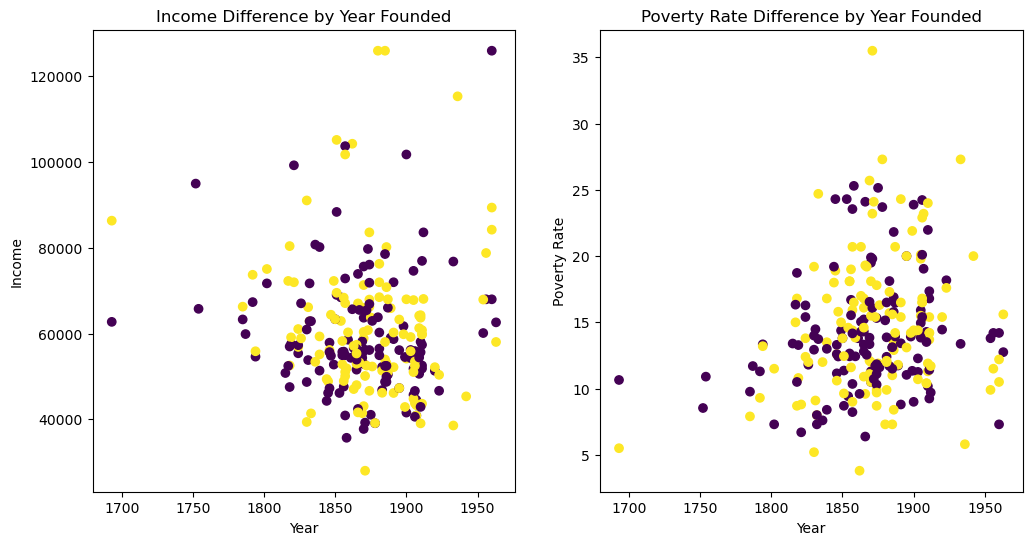

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(analysis_df["Year"], analysis_df["income"], c = analysis_df["Treatment"])
ax2.scatter(analysis_df["Year"], analysis_df["poverty_rate"], c = analysis_df["Treatment"])

ax1.set_xlabel('Year')
ax1.set_ylabel('Income')
ax1.set_title('Income Difference by Year Founded')

ax2.set_xlabel('Year')
ax2.set_ylabel('Poverty Rate')
ax2.set_title('Poverty Rate Difference by Year Founded')